# Word CEFR

## Import libraries

In [1]:
import os
import csv
import time
import gzip
import spacy
import sqlite3
import lemminflect

In [2]:
print(spacy.require_gpu())

True


In [3]:
NLP = spacy.load("en_core_web_trf", exclude=['parser', 'ner'])

## Prepare database

In [4]:
STAGE_ZONE_FILENAME = 'word_cefr_stage.db'
ORIGINAL_DATABASE_FILENAME = 'word_cefr.db'

START_YEAR_DATA_ANALYZE = 1900
DATASET_MAX_YEAR = 2019

MIN_STEM_VALID_PROBABILITY = 0.5

In [5]:
def create_tables(cursor: sqlite3.Cursor, conn: sqlite3.Connection):
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS words (
        word_id INTEGER PRIMARY KEY AUTOINCREMENT,
        word VARCHAR(25) UNIQUE NOT NULL,
        stem_word_id INTEGER,

        FOREIGN KEY (stem_word_id) REFERENCES words (word_id)
    )
    ''')

    cursor.execute('''
    CREATE INDEX IF NOT EXISTS idx_word ON words (word)
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS years (
            year_id INTEGER PRIMARY KEY AUTOINCREMENT,
            year INTEGER UNIQUE NOT NULL
        )
    ''')

    cursor.execute('''
    CREATE INDEX IF NOT EXISTS idx_year ON years (year)
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS pos_tags (
            tag_id INTEGER PRIMARY KEY AUTOINCREMENT,
            tag VARCHAR(4) UNIQUE NOT NULL,
            description VARCHAR(40) NOT NULL
        )
    ''')

    cursor.execute('''
    CREATE INDEX IF NOT EXISTS idx_pos_tag ON pos_tags (tag)
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS word_pos (
        word_pos_id INTEGER PRIMARY KEY AUTOINCREMENT,
        word_id INTEGER NOT NULL,
        pos_tag_id INTEGER NOT NULL,
        lemma_word_id INTEGER,

        UNIQUE (word_id, pos_tag_id),
        FOREIGN KEY (word_id) REFERENCES words(word_id),
        FOREIGN KEY (pos_tag_id) REFERENCES pos_tags(tag_id),
        FOREIGN KEY (lemma_word_id) REFERENCES words(word_id)
    )
    ''')

    cursor.execute('''
    CREATE INDEX IF NOT EXISTS idx_word_pos_lemma ON word_pos (lemma_word_id)
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS year_frequency (
            word_pos_id INTEGER,
            year_id INTEGER,
            frequency INTEGER NOT NULL,

            PRIMARY KEY (word_pos_id, year_id),
            FOREIGN KEY (word_pos_id) REFERENCES word_pos(word_pos_id),
            FOREIGN KEY (year_id) REFERENCES years(year_id)
        )
    ''')

    cursor.execute('''
    CREATE INDEX IF NOT EXISTS idx_year_frequency_word_id ON year_frequency (word_pos_id)
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS sources (
        source_id INTEGER PRIMARY KEY AUTOINCREMENT,
        source_title VARCHAR(32) UNIQUE NOT NULL
    )
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS word_pos_levels (
        word_pos_id INTEGER NOT NULL,
        source_id INTEGER NOT NULL,
        level REAL NOT NULL,

        PRIMARY KEY (word_pos_id, source_id),
        FOREIGN KEY (word_pos_id) REFERENCES word_pos (word_pos_id),
        FOREIGN KEY (source_id) REFERENCES sources (source_id)
    )
    ''')

    cursor.execute('''
        CREATE INDEX IF NOT EXISTS idx_word_pos_id_levels ON word_pos_levels (word_pos_id)
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS categories (
        category_id INTEGER PRIMARY KEY AUTOINCREMENT,
        category_title VARCHAR(255) NOT NULL
    )
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS word_categories (
        word_pos_id INTEGER NOT NULL,
        category_id INTEGER NOT NULL,

        UNIQUE (word_pos_id, category_id),
        FOREIGN KEY (word_pos_id) REFERENCES word_pos(word_pos_id),
        FOREIGN KEY (category_id) REFERENCES categories(category_id)
    )
    ''')

    cursor.execute('''
    CREATE INDEX IF NOT EXISTS idx_word_categories_word_pos_id ON word_categories (word_pos_id)
    ''')

    conn.commit()

In [6]:
conn = sqlite3.connect(STAGE_ZONE_FILENAME)
cursor = conn.cursor()

create_tables(cursor, conn)

In [7]:
years_to_insert = [(year,) for year in range(START_YEAR_DATA_ANALYZE, DATASET_MAX_YEAR + 1)]
cursor.executemany('INSERT OR IGNORE INTO years(year) VALUES (?)', years_to_insert)
conn.commit()

In [7]:
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
POS_TAGS = [
    ('CC', 'Coordinating conjunction'),
    ('CD', 'Cardinal number'),
    ('DT', 'Determiner'),
    ('EX', 'Existential there'),
    ('FW', 'Foreign word'),
    ('IN', 'Preposition or subordinating conjunction'),
    ('JJ', 'Adjective'),
    ('JJR', 'Adjective, comparative'),
    ('JJS', 'Adjective, superlative'),
    ('LS', 'List item marker'),
    ('MD', 'Modal'),
    ('NN', 'Noun, singular or mass'),
    ('NNS', 'Noun, plural'),
    ('NNP', 'Proper noun, singular'),
    ('NNPS', 'Proper noun, plural'),
    ('PDT', 'Predeterminer'),
    ('POS', 'Possessive ending'),
    ('PRP', 'Personal pronoun'),
    ('PRP$', 'Possessive pronoun'),
    ('RB', 'Adverb'),
    ('RBR', 'Adverb, comparative'),
    ('RBS', 'Adverb, superlative'),
    ('RP', 'Particle'),
    ('SYM', 'Symbol'),
    ('TO', 'To'),
    ('UH', 'Interjection'),
    ('VB', 'Verb, base form'),
    ('VBD', 'Verb, past tense'),
    ('VBG', 'Verb, gerund or present participle'),
    ('VBN', 'Verb, past participle'),
    ('VBP', 'Verb, non-3rd person singular present'),
    ('VBZ', 'Verb, 3rd person singular present'),
    ('WDT', 'Wh-determiner'),
    ('WP', 'Wh-pronoun'),
    ('WP$', 'Possessive wh-pronoun'),
    ('WRB', 'Wh-adverb')
]

In [9]:
cursor.executemany('INSERT OR IGNORE INTO pos_tags(tag, description) VALUES (?, ?)', POS_TAGS)
conn.commit()

## Load valid word list

In [8]:
valid_word_filepath = './datasets/valid_words_sorted_by_frequency.csv'
VALID_WORDS = dict()

parse_start_time = time.time()
with open(valid_word_filepath, 'r') as valid_words_dataset:
    csv_reader = csv.DictReader(valid_words_dataset)
    for row in csv_reader:
        word_id = row['Rank']
        word = row['Word']
        stem = row['Stem']
        stem_valid_probability = row['Stem valid probability']

        if stem and float(stem_valid_probability) >= MIN_STEM_VALID_PROBABILITY:
            VALID_WORDS[word] = [word_id, stem]
        else:
            VALID_WORDS[word] = [word_id, None]

parse_end_time = time.time()

print("Total valid words:", len(VALID_WORDS))
print("Total parse time: ", round(parse_end_time - parse_start_time, 2), "s")

Total valid words: 172782
Total parse time:  0.7 s


In [11]:
list_to_insert_in_db = []
for word, word_info in VALID_WORDS.items():
    word_id, stem = word_info
    if stem:
        stem_word_id = VALID_WORDS[stem][0]
        list_to_insert_in_db.append((word_id, word, stem_word_id))
    else:
        list_to_insert_in_db.append((word_id, word, None))

In [12]:
cursor.executemany('INSERT OR IGNORE INTO words (word_id, word, stem_word_id) VALUES (?, ?, ?)', list_to_insert_in_db)
conn.commit()

In [13]:
del list_to_insert_in_db

## Word mapping

In [9]:
DIFFICULTY_MAPPING = {
    'A1': 1,
    'A2': 2,
    'B1': 3,
    'B2': 4,
    'C1': 5,
    'C2': 6
}

DIFFICULTY_MAPPING_REVERSE = {
    1: 'A1',
    2: 'A2',
    3: 'B1',
    4: 'B2',
    5: 'C1',
    6: 'C2'
}

GT_POS_MAPPING = {
    'conjunction': 'CC',
    'infinitive-to': 'TO',
    'interjection': 'UH',
    'modal auxiliary': 'MD',
    'number': 'CD',
    'particle': 'RP',
    'preposition': 'IN',
}

POSSIBLE_POS_MAPPING = {
    'adjective': 'JJ',
    'adverb': 'RB',
    'determiner': 'DT',
    'noun': 'NN',
    'pronoun': 'PRP',
    'verb': 'VB'
}

REVERSE_POSSIBLE_POS_MAPPING = {
    'JJ': 'adjective',
    'JJR': 'adjective',
    'JJS': 'adjective',
    'RB': 'adverb',
    'RBR': 'adverb',
    'RBS': 'adverb',
    'WRB': 'adverb',
    'DT': 'determiner',
    'PDT': 'determiner',
    'WDT': 'determiner',
    'PRP': 'determiner',
    'PRP$': 'determiner',
    'VB': 'verb',
    'VBD': 'verb',
    'VBG': 'verb',
    'VBN': 'verb',
    'VBP': 'verb',
    'VBZ': 'verb',
    'MD': 'modal auxiliary',
    'NN': 'noun',
    'NNS': 'noun',
    'NNP': 'noun',
    'NNPS': 'noun',
    'WP': 'pronoun',
    'WP$': 'pronoun'
}

UNIGRAMS_WORD_POS_MAPPING = {
    "NOUN": "noun",
    "VERB": "verb",
    "ADJ": "adjective",
    "ADV": "adverb",
    "PRON": "pronoun",
    "DET": "determiner",
    "ADP": "preposition",
    "NUM": "number",
    "CONJ": "conjunction",
    "PRT": "particle",
}

LEMMINFLECT_UPOS_TAGS_MAPPING = {
    'noun': 'NOUN',
    'pronoun': 'PROPN',
    'verb': 'VERB',
    'adverb': 'ADV',
    'adjective': 'ADJ',
    'modal auxiliary': 'AUX'
}

LEMMINFLECT_UPOS_TAGS = {'NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV', 'AUX'}

WORD_POS_TO_ID = dict()
for i, tag_data in enumerate(POS_TAGS, 1):
    tag = tag_data[0]
    WORD_POS_TO_ID[tag] = i


def year_to_id(year: int):
    return year - START_YEAR_DATA_ANALYZE + 1


def get_lemma(word: str, upos: str) -> str | None:
    lemma = lemminflect.getLemma(word, upos=upos)

    if len(lemma) > 1:
        return min(*lemma, key=len)

    if len(lemma):
        return lemma[0]

    return None


def get_lemma_from_unigram_dataset(word: str, dataset_pos: str) -> str | None:
    if dataset_pos == 'PRON':
        return get_lemma(word, 'PROPN')

    if dataset_pos == 'VERB':
        verb_lemma = get_lemma(word, 'VERB')
        aux_lemma = get_lemma(word, 'AUX')

        if aux_lemma is None:
            return verb_lemma

        if verb_lemma is None:
            return aux_lemma

        return min(verb_lemma, aux_lemma, key=len)

    if dataset_pos in LEMMINFLECT_UPOS_TAGS:
        return get_lemma(word, dataset_pos)

    return None


def get_lemma_valid_pos(word: str, pos: str) -> str | None:
    reverse_pos = REVERSE_POSSIBLE_POS_MAPPING.get(pos)
    if reverse_pos is None:
        return

    upos = LEMMINFLECT_UPOS_TAGS_MAPPING.get(reverse_pos)
    if upos is None:
        return

    return get_lemma(word, upos)


def get_word_tag(word: str) -> str:
    return NLP(word)[0].pos_


def get_valid_pos(word: str, pos: str) -> str:
    if word == 'to':
        return 'TO'

    gt_pos = GT_POS_MAPPING.get(pos)
    if gt_pos is not None:
        return gt_pos

    if pos in ('be-verb', 'do-verb', 'have-verb'):
        pos = 'verb'

    word_tag = get_word_tag(word)
    if pos == REVERSE_POSSIBLE_POS_MAPPING.get(word_tag):
        return word_tag

    return POSSIBLE_POS_MAPPING.get(pos)


def get_id_and_insert_source(source_title: str) -> int:
    cursor.execute('SELECT source_id FROM sources WHERE source_title = ?', (source_title,))
    source_record = cursor.fetchone()
    if source_record is not None:
        return source_record[0]

    cursor.execute('INSERT INTO sources (source_title) VALUES (?)', (source_title,))
    conn.commit()

    return cursor.lastrowid


def get_id_and_insert_word_pos(word_id: int, pos: str) -> int:
    pos_tag_id = WORD_POS_TO_ID.get(pos)
    cursor.execute('SELECT word_pos_id FROM word_pos WHERE word_id = ? AND pos_tag_id = ?', (word_id, pos_tag_id))
    word_pos_record = cursor.fetchone()
    if word_pos_record is not None:
        return word_pos_record[0]

    cursor.execute('INSERT INTO word_pos (word_id, pos_tag_id) VALUES (?, ?)', (word_id, pos_tag_id))
    return cursor.lastrowid


def update_word_pos_level(word_pos_id: int, source_id: int, new_level_value: float, i: int):
    cursor.execute('''
        UPDATE word_pos_levels
        SET level = ((level * ?) + ?) / ?
        WHERE word_pos_id = ?
        AND source_id = ?
    ''', (i, new_level_value, i + 1, word_pos_id, source_id))

## Parse frequency data

In [15]:
UNIGRAMS_DATA_FOLDER = 'datasets/unigrams/'
UNIGRAMS_DATA_FILES = [file for file in os.listdir(UNIGRAMS_DATA_FOLDER) if file.endswith('.gz')]

UNIGRAMS_BATCH_SIZE = 500000
UNIGRMS_MIN_FREQUENCY = 10000

def unigram_parse_word_pos(word: str) -> tuple[str, str | None]:
    last_underscore_index = word.rfind('_')
    if last_underscore_index == -1:
        return word, None

    word_substr = word[:last_underscore_index]
    pos_substr = word[last_underscore_index + 1:]

    return word_substr, pos_substr


def process_unigram(cursor: sqlite3.Cursor, word: str, word_id: int, pos_name: str, dataset_pos: str, frequencies: list[tuple[int, int]]) -> bool | None:
    pos_tag = get_valid_pos(word, pos_name)
    pos_tag_id = WORD_POS_TO_ID.get(pos_tag)

    cursor.execute('SELECT word_pos_id FROM word_pos WHERE word_id = ? AND pos_tag_id = ?', (word_id, pos_tag_id))
    word_pos_id_result = cursor.fetchone()

    if word_pos_id_result:
        word_pos_id = word_pos_id_result[0]
    else:
        lemma = get_lemma_from_unigram_dataset(word, dataset_pos)
        if lemma is None or lemma == word:
            lemma_word_id = None
        else:
            lemma_word_info = VALID_WORDS.get(lemma)
            if lemma_word_info is None:
                lemma_word_id = None
            else:
                lemma_word_id = lemma_word_info[0]

        cursor.execute('INSERT INTO word_pos (word_id, pos_tag_id, lemma_word_id) VALUES (?, ?, ?)', (word_id, pos_tag_id, lemma_word_id))
        word_pos_id = cursor.lastrowid

    if word_pos_id_result:
        for year, frequency in frequencies:
            year_id = year_to_id(year)

            cursor.execute('''
                SELECT frequency FROM year_frequency
                WHERE word_pos_id = ? AND year_id = ?
            ''', (word_pos_id, year_id))

            existing_record = cursor.fetchone()
            if existing_record:
                new_frequency = existing_record[0] + int(frequency)
                cursor.execute('''
                    UPDATE year_frequency
                    SET frequency = ?
                    WHERE word_pos_id = ? AND year_id = ?
                ''', (new_frequency, word_pos_id, year_id))
            else:
                cursor.execute('''
                    INSERT INTO year_frequency (word_pos_id, year_id, frequency)
                    VALUES (?, ?, ?)
                ''', (word_pos_id, year_id, frequency))

        return False

    for year, frequency in frequencies:
        year_id = year_to_id(year)
        cursor.execute('''
            INSERT INTO year_frequency (word_pos_id, year_id, frequency)
            VALUES (?, ?, ?)
        ''', (word_pos_id, year_id, frequency))

    return True


def unigram_print_statistic(elapsed_time: float, inserted: int, updated: int):
    print('T:', '{:.2f}'.format(elapsed_time).ljust(6), 's |', 'I:', str(inserted).ljust(4), 'U:', updated)

In [16]:
for unigram_data_file in UNIGRAMS_DATA_FILES:
    print('\tProcessing:', unigram_data_file)

    filepath = os.path.join(UNIGRAMS_DATA_FOLDER, unigram_data_file)
    processed_lines = 0
    inserted = 0
    updated = 0

    with gzip.open(filepath, 'rt', encoding='utf-8') as gz_file:
        batch_start_time = time.time()
        for line in gz_file:
            processed_lines += 1

            splitted_line = line.split('\t')
            unigram = splitted_line[0]

            unigram, dataset_pos = unigram_parse_word_pos(unigram)
            if dataset_pos is None:
                continue # SKIP WORD: NO POS

            pos_name = UNIGRAMS_WORD_POS_MAPPING.get(dataset_pos)
            if pos_name is None:
                continue # SKIP WORD: INVALID POS

            word = unigram.lower()
            word_info = VALID_WORDS.get(word)
            if word_info is None:
                continue # SKIP WORD: INVALID WORD

            word_id = word_info[0]

            years_data = splitted_line[1:]
            years_frequencies_pairs = []

            count = 0
            for year_data in years_data:
                splitted_years_data = year_data.split(',')
                year = int(splitted_years_data[0])
                if year >= START_YEAR_DATA_ANALYZE and year <= DATASET_MAX_YEAR:
                    frequency = int(splitted_years_data[1])
                    years_frequencies_pairs.append((year, frequency))
                    count += frequency

            if count >= UNIGRMS_MIN_FREQUENCY:
                processing_result = process_unigram(cursor, word, word_id, pos_name, dataset_pos, years_frequencies_pairs)
                if not processing_result is None:
                    if processing_result:
                        inserted += 1
                    else:
                        updated += 1

            if UNIGRAMS_BATCH_SIZE and processed_lines >= UNIGRAMS_BATCH_SIZE:
                conn.commit()
                unigram_print_statistic(time.time() - batch_start_time, inserted, updated)
                inserted = 0
                updated = 0
                processed_lines = 0
                batch_start_time = time.time()

        conn.commit()
        unigram_print_statistic(time.time() - batch_start_time, inserted, updated)

    print('-' * 30)

	Processing: 1-00006-of-00024.gz
T: 33.52  s | I: 1893 U: 85
T: 30.36  s | I: 1672 U: 272
T: 32.81  s | I: 1621 U: 469
T: 31.10  s | I: 1442 U: 636
T: 28.43  s | I: 1170 U: 809
T: 27.69  s | I: 1078 U: 907
T: 6.07   s | I: 196  U: 241
------------------------------
	Processing: 1-00007-of-00024.gz
T: 50.59  s | I: 3343 U: 266
T: 49.10  s | I: 3076 U: 500
T: 49.41  s | I: 2844 U: 706
T: 49.74  s | I: 2624 U: 973
T: 49.56  s | I: 2393 U: 1175
T: 48.45  s | I: 2116 U: 1417
T: 36.87  s | I: 1523 U: 1191
------------------------------
	Processing: 1-00008-of-00024.gz
T: 51.86  s | I: 3055 U: 733
T: 51.56  s | I: 2856 U: 923
T: 53.75  s | I: 2779 U: 1122
T: 55.16  s | I: 2537 U: 1299
T: 56.41  s | I: 2356 U: 1428
T: 56.14  s | I: 2087 U: 1584
T: 44.88  s | I: 1610 U: 1370
------------------------------
	Processing: 1-00009-of-00024.gz
T: 54.97  s | I: 3112 U: 411
T: 56.25  s | I: 2868 U: 677
T: 55.41  s | I: 2644 U: 905
T: 56.93  s | I: 2397 U: 1217
T: 56.49  s | I: 2187 U: 1319
T: 55.70  s 

## Parse CERF-J word list

In [10]:
CERF_J_SOURCE_TITLE = 'CERF-J'
CERF_J_SOURCE_ID = get_id_and_insert_source(CERF_J_SOURCE_TITLE)

print('Source id:', CERF_J_SOURCE_ID)

Source id: 1


In [11]:
cefr_j_duplicate_counter_dict = dict()

with open('datasets/word_list_cefr.csv', 'r', encoding='utf-8') as file:
    cefr_data = csv.DictReader(file, delimiter=';')
    for row in cefr_data:
        headword = row['headword'].strip().replace('.', '').lower()
        if headword.find(' ') != -1 or headword.find('?') != -1:
            continue

        pos = get_valid_pos(headword, row['pos'])
        if pos is None:
            continue

        cefr_level = row['CEFR']

        difficulty = DIFFICULTY_MAPPING.get(cefr_level, 3)

        word_info = VALID_WORDS.get(headword)
        if word_info is None:
            continue

        word_id = word_info[0]
        word_pos_id = get_id_and_insert_word_pos(word_id, pos)

        duplicate_count = cefr_j_duplicate_counter_dict.get(word_pos_id)
        if duplicate_count is None:
            cursor.execute('INSERT INTO word_pos_levels (word_pos_id, source_id, level) VALUES (?, ?, ?)',
                        (word_pos_id, CERF_J_SOURCE_ID, difficulty))

            cefr_j_duplicate_counter_dict[word_pos_id] = 1
        else:
            update_word_pos_level(word_pos_id, CERF_J_SOURCE_ID, difficulty, duplicate_count)
            cefr_j_duplicate_counter_dict[word_pos_id] = duplicate_count + 1

        core_inventory_1 = row['CoreInventory 1']
        core_inventory_2 = row['CoreInventory 2']
        threshold = row['Threshold']

        for category_title in (core_inventory_1, core_inventory_2, threshold):
            if category_title is None:
                continue

            category_title = category_title.strip()
            if not category_title:
                continue

            cursor.execute('SELECT category_id FROM categories WHERE category_title = ?', (category_title,))
            category_record = cursor.fetchone()

            if category_record is None:
                cursor.execute('INSERT INTO categories (category_title) VALUES (?)', (category_title,))
                category_id = cursor.lastrowid
            else:
                category_id = category_record[0]

            cursor.execute('INSERT OR IGNORE INTO word_categories (word_pos_id, category_id) VALUES (?, ?)', (word_pos_id, category_id))

conn.commit()

## Calculate frequencies to CEFR relationship

In [12]:
cursor.execute('''
    SELECT wpl.level, total_frequency
    FROM word_pos_levels wpl
    JOIN (
        SELECT wp.word_pos_id, SUM(yf.frequency) AS total_frequency
        FROM word_pos wp
        JOIN year_frequency yf ON wp.word_pos_id = yf.word_pos_id
        GROUP BY wp.word_pos_id
    ) AS total_freq_per_word ON wpl.word_pos_id = total_freq_per_word.word_pos_id
''')

total_frequencies_data = cursor.fetchall()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

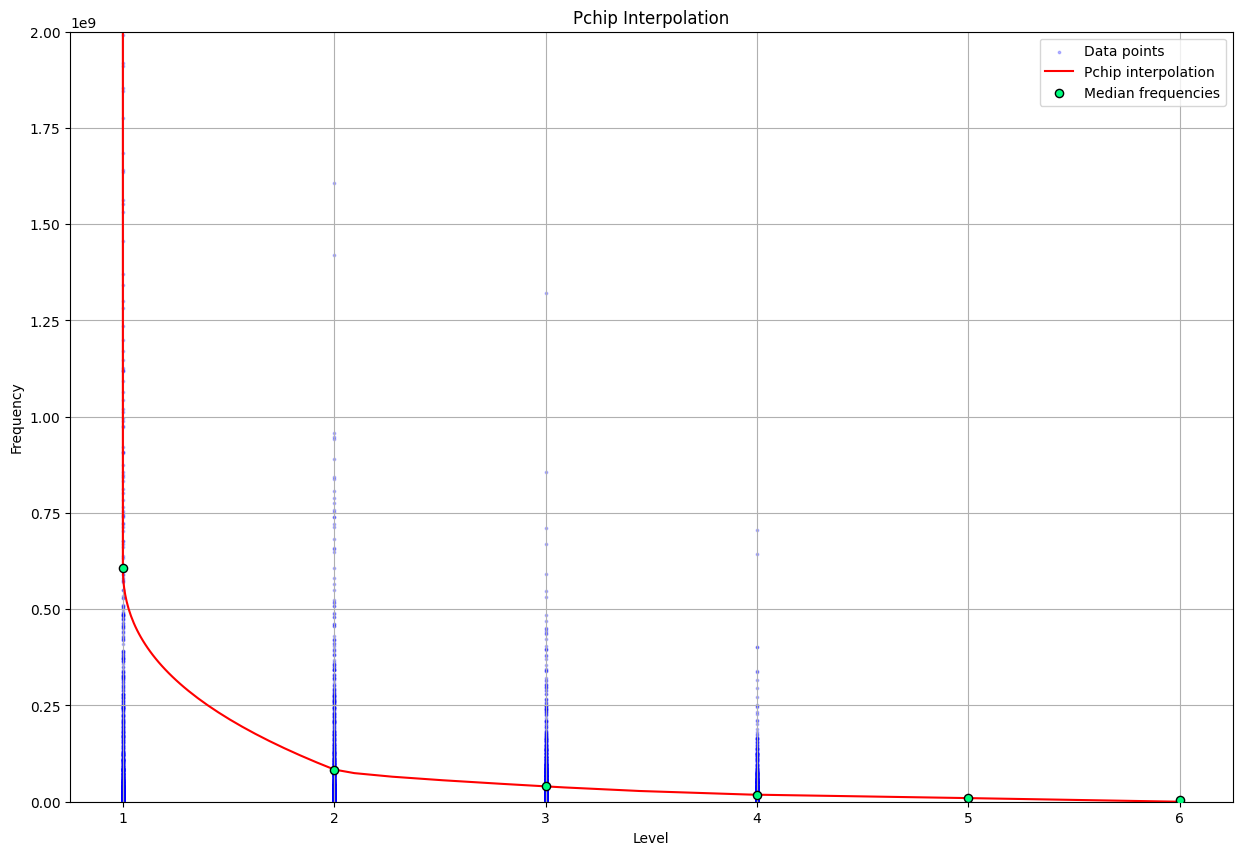

In [23]:
levels, frequencies = zip(*total_frequencies_data)

levels = np.array(levels)
frequencies = np.array(frequencies)

rounded_levels = [round(level) for level in levels]
unique_levels = np.arange(1, 7)

median_frequencies = [np.mean(frequencies[rounded_levels == level]) for level in unique_levels]

# C1: 9371236
# C2: 4563849
median_frequencies[4] = 9371236
median_frequencies[5] = 4563849

interpolator = PchipInterpolator(np.flip(median_frequencies), np.flip(unique_levels))

def frequency_to_level(freq: float):
    if freq > max(median_frequencies):
        return 1
    elif freq < min(median_frequencies):
        return 6
    else:
        return float(interpolator(freq))

y_values = np.linspace(min(frequencies), max(frequencies), 10000)
x_values = np.array([frequency_to_level(freq) for freq in y_values])

plt.figure(figsize=(15, 10))
plt.scatter(levels, frequencies, color='blue', alpha=0.25, s=3, label='Data points', zorder=1)
plt.plot(x_values, y_values, color='red', linewidth=1.5, label='Pchip interpolation', zorder=2)
plt.scatter(unique_levels, median_frequencies, color='springgreen', edgecolors='black', alpha=1, s=35, label='Median frequencies', zorder=3)

plt.ylim(0, 2e9)

plt.xlabel('Level')
plt.ylabel('Frequency')
plt.title('Pchip Interpolation')

plt.legend()
plt.grid()
plt.show()

In [24]:
def large_value_formatter(value: float) -> str:
    if value > 1e6:
        return str(round(value / 1e6, 2)) + 'M'

    if value > 1e3:
        return str(round(value / 1e3, 2)) + 'K'

    return str(round(value))

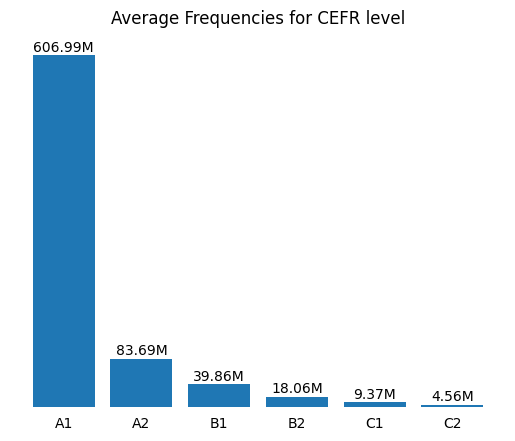

In [25]:
plt.title('Average Frequencies for CEFR level', pad=10)
plt.bar([DIFFICULTY_MAPPING_REVERSE.get(level) for level in unique_levels], median_frequencies)

for i, v in enumerate(median_frequencies):
    plt.text(i, v + max(median_frequencies) * .01, large_value_formatter(v), ha='center')

plt.yticks([])
plt.tick_params(axis='x', which='both', bottom=False, top=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

In [26]:
print('\tAverage frequencies:')
for i, level_frequency in enumerate(median_frequencies, 1):
    print(f'{DIFFICULTY_MAPPING_REVERSE.get(i)}: {round(level_frequency)}')

	Average frequencies:
A1: 606986397
A2: 83687996
B1: 39858914
B2: 18064351
C1: 9371236
C2: 4563849


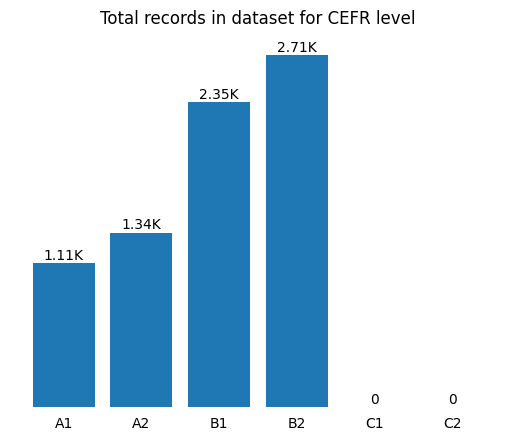

In [27]:
plt.title('Total records in dataset for CEFR level', pad=10)

total_data_for_level = [len(frequencies[rounded_levels == level]) for level in unique_levels]

plt.bar([DIFFICULTY_MAPPING_REVERSE.get(level) for level in unique_levels], total_data_for_level)

for i, v in enumerate(total_data_for_level):
    plt.text(i, v + max(total_data_for_level) * .01, large_value_formatter(v), ha='center')

plt.yticks([])
plt.tick_params(axis='x', which='both', bottom=False, top=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

## Set not matched words level

### Add new source for computed levels

In [28]:
COMPUTED_SOURCE_TITLE = 'Computed'
COMPUTED_SOURCE_ID = get_id_and_insert_source(COMPUTED_SOURCE_TITLE)

print('Source id:', COMPUTED_SOURCE_ID)

Source id: 2


### Init functions to set word levels

In [29]:
def compute_levels(data_to_compute: list[tuple[int, int]]):
    result = []
    for id, frequency in data_to_compute:
        level = frequency_to_level(frequency)
        result.append((id, level))
    return result


def set_predicted_word_levels(data_to_compute: list[tuple[int, int]]):
    computed_data = compute_levels(data_to_compute)
    cursor.executemany('''
        INSERT INTO word_pos_levels (word_pos_id, source_id, level)
        VALUES (?, {}, ?)
    '''.format(COMPUTED_SOURCE_ID), (computed_data))

    conn.commit()

#### Set level to word pos as average level of other word pos for the same word

In [30]:
def set_level_as_avg_word_pos_level() -> int:
    cursor.execute('''
        SELECT w.word_id, wp.word_pos_id
        FROM word_pos wp
        JOIN words w ON wp.word_id = w.word_id
        LEFT JOIN word_pos_levels wpl ON wp.word_pos_id = wpl.word_pos_id
        WHERE wpl.word_pos_id IS NULL
        AND EXISTS (
            SELECT 1
            FROM word_pos_levels wpl2
            JOIN word_pos wp2 ON wpl2.word_pos_id = wp2.word_pos_id
            JOIN words w2 ON wp2.word_id = w2.word_id
            WHERE w.word = w2.word
            AND wpl2.word_pos_id <> wp.word_pos_id
        )
    ''')

    word_pos_level_avg_wp = cursor.fetchall()
    word_pos_level_avg_wp_tuples = [(word_pos_id, word_id) for word_id, word_pos_id in word_pos_level_avg_wp]

    cursor.executemany('''
        INSERT INTO word_pos_levels (word_pos_id, source_id, level)  
        SELECT ?, {}, AVG(wpl.level)
        FROM words w
        JOIN word_pos wp ON w.word_id = wp.word_id
        JOIN word_pos_levels wpl ON wp.word_pos_id = wpl.word_pos_id
        GROUP BY w.word_id
        HAVING w.word_id = ?
    '''.format(COMPUTED_SOURCE_ID), word_pos_level_avg_wp_tuples)

    conn.commit()

    return len(word_pos_level_avg_wp)

#### Set level based on average word pos levels for lemma

In [31]:
def set_level_as_avg_word_pos_lemma_level() -> int:
    cursor.execute('''
        SELECT wp.word_pos_id, AVG(wpl2.level)
        FROM word_pos wp
        JOIN words w ON wp.lemma_word_id = w.word_id
        JOIN word_pos wp2 ON w.word_id = wp2.word_id
        JOIN word_pos_levels wpl2 ON wp2.word_pos_id = wpl2.word_pos_id
        LEFT JOIN word_pos_levels wpl ON wp.word_pos_id = wpl.word_pos_id
        WHERE wpl.word_pos_id IS NULL
        GROUP BY wp.word_pos_id
    ''')

    word_pos_with_lemma_level = cursor.fetchall()

    word_pos_with_lemma_level_tuples = [(word_pos_id, avg_level) for word_pos_id, avg_level in word_pos_with_lemma_level]
    cursor.executemany('''
        INSERT INTO word_pos_levels (word_pos_id, source_id, level)  
        VALUES (?, {}, ?)
    '''.format(COMPUTED_SOURCE_ID), word_pos_with_lemma_level_tuples)

    conn.commit()

    return len(word_pos_with_lemma_level)

#### Set level based on average word pos levels for stem

In [32]:
def set_level_as_avg_word_pos_stem_level() -> int:
    cursor.execute('''
        SELECT wp.word_pos_id, AVG(wpl2.level)
        FROM word_pos wp
        JOIN words w ON wp.word_id = w.word_id
        JOIN word_pos wp2 ON w.stem_word_id = wp2.word_id
        JOIN word_pos_levels wpl2 ON wp2.word_pos_id = wpl2.word_pos_id
        LEFT JOIN word_pos_levels wpl ON wp.word_pos_id = wpl.word_pos_id
        WHERE wpl.word_pos_id IS NULL
        GROUP BY wp.word_pos_id
    ''')

    word_pos_with_stem_level = cursor.fetchall()

    word_pos_with_lemma_level_tuples = [(word_pos_id, avg_level) for word_pos_id, avg_level in word_pos_with_stem_level]
    cursor.executemany('''
        INSERT INTO word_pos_levels (word_pos_id, source_id, level)  
        VALUES (?, {}, ?)
    '''.format(COMPUTED_SOURCE_ID), word_pos_with_lemma_level_tuples)

    conn.commit()

    return len(word_pos_with_stem_level)

#### Set level based on average word pos lemma frequency

In [33]:
def set_level_as_avg_word_pos_lemma_frequency() -> int:
    cursor.execute('''
        SELECT wp.word_pos_id, SUM(yf.frequency)
        FROM word_pos wp
        JOIN words w ON wp.lemma_word_id = w.word_id
        JOIN word_pos wp2 ON w.word_id = wp2.word_id
        JOIN year_frequency yf ON wp2.word_pos_id = yf.word_pos_id
        LEFT JOIN word_pos_levels wpl ON wp.word_pos_id = wpl.word_pos_id
        WHERE wpl.word_pos_id IS NULL
        GROUP BY wp.word_pos_id
    ''')

    word_pos_to_compute_level_based_on_lemma = cursor.fetchall()

    set_predicted_word_levels(word_pos_to_compute_level_based_on_lemma)

    return len(word_pos_to_compute_level_based_on_lemma)

#### Set level based on average word pos stem frequency

In [34]:
def set_level_as_avg_word_pos_stem_frequency() -> int:
    cursor.execute('''
        SELECT wp.word_pos_id, SUM(yf.frequency)
        FROM word_pos wp
        JOIN words w ON wp.word_id = w.word_id
        JOIN word_pos wp2 ON w.stem_word_id = wp2.word_id
        JOIN year_frequency yf ON wp2.word_pos_id = yf.word_pos_id
        LEFT JOIN word_pos_levels wpl ON wp.word_pos_id = wpl.word_pos_id
        WHERE wpl.word_pos_id IS NULL
        GROUP BY wp.word_pos_id
    ''')

    word_pos_to_compute_level_based_on_stem = cursor.fetchall()

    set_predicted_word_levels(word_pos_to_compute_level_based_on_stem)

    return len(word_pos_to_compute_level_based_on_stem)

#### Set level to other words pos based on frequency

In [35]:
def set_all_word_pos_by_frequency() -> int:
    cursor.execute('''
        SELECT wp.word_pos_id, SUM(yf.frequency)
        FROM word_pos wp
        JOIN year_frequency yf ON wp.word_pos_id = yf.word_pos_id
        LEFT JOIN word_pos_levels wpl ON wp.word_pos_id = wpl.word_pos_id
        WHERE wpl.word_pos_id IS NULL
        GROUP BY wp.word_pos_id
    ''')

    word_pos_to_compute_level = cursor.fetchall()

    set_predicted_word_levels(word_pos_to_compute_level)

    return len(word_pos_to_compute_level)

## Set levels

In [36]:
counter = None
iteration_counter = 1

avg_word_pos_level = set_level_as_avg_word_pos_level()
print('Set level as avg word pos level:', avg_word_pos_level)

print('-' * 30)

while counter != 0:
    print(f'\tIteration {iteration_counter}:')

    avg_word_pos_lemma_level = set_level_as_avg_word_pos_lemma_level()
    print('Set level as avg word pos lemma level:', avg_word_pos_lemma_level)

    avg_word_pos_stem_level = set_level_as_avg_word_pos_stem_level()
    print('Set level as avg word pos stem level:', avg_word_pos_stem_level)

    avg_word_pos_level = set_level_as_avg_word_pos_level()
    print('Set level as avg word pos level:', avg_word_pos_level)

    iteration_counter += 1
    counter = avg_word_pos_lemma_level + avg_word_pos_stem_level

    print('\nTotal set on iteration:', counter)
    print('-' * 30)

print('\tStep 1:')

avg_word_pos_stem_frequency = set_level_as_avg_word_pos_stem_frequency()
print('Set level as avg word pos stem frequency:', avg_word_pos_stem_frequency)

avg_word_pos_lemma_level = set_level_as_avg_word_pos_lemma_level()
print('Set level as avg word pos lemma level 1:', avg_word_pos_lemma_level)

avg_word_pos_stem_level = set_level_as_avg_word_pos_stem_level()
print('Set level as avg word pos stem level 1:', avg_word_pos_stem_level)

avg_word_pos_level = set_level_as_avg_word_pos_level()
print('Set level as avg word pos level 1:', avg_word_pos_level)

print('\tStep 2:')

avg_word_pos_lemma_frequency = set_level_as_avg_word_pos_lemma_frequency()
print('Set level as avg word pos lemma frequency:', avg_word_pos_lemma_frequency)

avg_word_pos_lemma_level = set_level_as_avg_word_pos_lemma_level()
print('Set level as avg word pos lemma level 2:', avg_word_pos_lemma_level)

avg_word_pos_stem_level = set_level_as_avg_word_pos_stem_level()
print('Set level as avg word pos stem level 2:', avg_word_pos_stem_level)

avg_word_pos_level = set_level_as_avg_word_pos_level()
print('Set level as avg word pos level 2:', avg_word_pos_level)

print('-' * 30)

all_word_pos_by_frequency = set_all_word_pos_by_frequency()
print('Set level based on frequency:', all_word_pos_by_frequency)

Set level as avg word pos level: 6303
------------------------------
	Iteration 1:
Set level as avg word pos lemma level: 15372
Set level as avg word pos stem level: 26561
Set level as avg word pos level: 1643

Total set on iteration: 41933
------------------------------
	Iteration 2:
Set level as avg word pos lemma level: 321
Set level as avg word pos stem level: 365
Set level as avg word pos level: 76

Total set on iteration: 686
------------------------------
	Iteration 3:
Set level as avg word pos lemma level: 17
Set level as avg word pos stem level: 11
Set level as avg word pos level: 3

Total set on iteration: 28
------------------------------
	Iteration 4:
Set level as avg word pos lemma level: 0
Set level as avg word pos stem level: 0
Set level as avg word pos level: 0

Total set on iteration: 0
------------------------------
	Step 1:
Set level as avg word pos stem frequency: 44584
Set level as avg word pos lemma level 1: 356
Set level as avg word pos stem level 1: 0
Set level 

## Load from stage zone to DB

In [37]:
def generate_word_frequency_view(cursor: sqlite3.Cursor, start_year: int, last_year: int):
    dynamic_sql = f'''
        CREATE VIEW IF NOT EXISTS word_pos_frequency_view AS
        SELECT
            w.word_id,
            wp.word_pos_id,
            w.word,
            pt.tag,
            COALESCE(SUM(yf.frequency), 0) AS total_frequency,
            {
                ', '.join([
                    f'MAX(CASE WHEN y.year = {year} THEN yf.frequency ELSE 0 END) AS "{year}"'
                    for year in range(start_year, last_year + 1)
                ])
            }
        FROM words w
        JOIN word_pos wp ON w.word_id = wp.word_id
        JOIN pos_tags pt ON wp.pos_tag_id = pt.tag_id
        LEFT JOIN year_frequency yf ON wp.word_pos_id = yf.word_pos_id
        LEFT JOIN years y ON yf.year_id = y.year_id
        GROUP BY wp.word_pos_id
    '''

    cursor.execute(dynamic_sql)


def create_views(cursor: sqlite3.Cursor, conn: sqlite3.Connection):
    cursor.execute('''
        CREATE VIEW IF NOT EXISTS word_pos_info_view AS
        SELECT 
            w.word_id,
            wp.word_pos_id,
            w.word,
            pt.tag,
            ROUND(AVG(wpl.level), 2) AS average_level,
            (SELECT GROUP_CONCAT(c.category_title, '; ')
                FROM word_categories wc
                JOIN categories c ON wc.category_id = c.category_id
                WHERE wc.word_pos_id = wp.word_pos_id
            ) AS categories
        FROM words w
        JOIN word_pos wp ON w.word_id = wp.word_id
        JOIN pos_tags pt ON wp.pos_tag_id = pt.tag_id
        LEFT JOIN word_pos_levels wpl ON wp.word_pos_id = wpl.word_pos_id
        GROUP BY wp.word_pos_id
    ''')

    generate_word_frequency_view(cursor, START_YEAR_DATA_ANALYZE, DATASET_MAX_YEAR)

    conn.commit()

In [38]:
conn_main = sqlite3.connect(ORIGINAL_DATABASE_FILENAME)
cursor_main = conn_main.cursor()

create_tables(cursor_main, conn_main)
create_views(cursor_main, conn_main)

In [39]:
cursor_main.execute('ATTACH DATABASE ? AS stage', (STAGE_ZONE_FILENAME,))

cursor_main.execute('INSERT INTO main.words SELECT * FROM stage.words')
cursor_main.execute('INSERT INTO main.years SELECT * FROM stage.years')
cursor_main.execute('INSERT INTO main.year_frequency SELECT * FROM stage.year_frequency')
cursor_main.execute('INSERT INTO main.pos_tags SELECT * FROM stage.pos_tags')
cursor_main.execute('INSERT INTO main.word_pos SELECT * FROM stage.word_pos')
cursor_main.execute('INSERT INTO main.sources SELECT * FROM stage.sources')
cursor_main.execute('INSERT INTO main.word_pos_levels SELECT * FROM stage.word_pos_levels')
cursor_main.execute('INSERT INTO main.categories SELECT * FROM stage.categories')
cursor_main.execute('INSERT INTO main.word_categories SELECT * FROM stage.word_categories')

conn_main.commit()

cursor_main.execute('DETACH DATABASE stage')
conn_main.commit()

In [ ]:
conn.close()
conn_main.close()